In [1]:
import pandas as pd
import json
import pyomo.environ as pyo
from pyomo.util.infeasible import *
import networkx as nx
import matplotlib.pyplot as plt

## Data 

In [2]:
with open("../data/mock_dataset.json") as f:
    d = json.load(f)
nodes, channels = pd.DataFrame(d["nodes"]), pd.DataFrame(d["edges"])

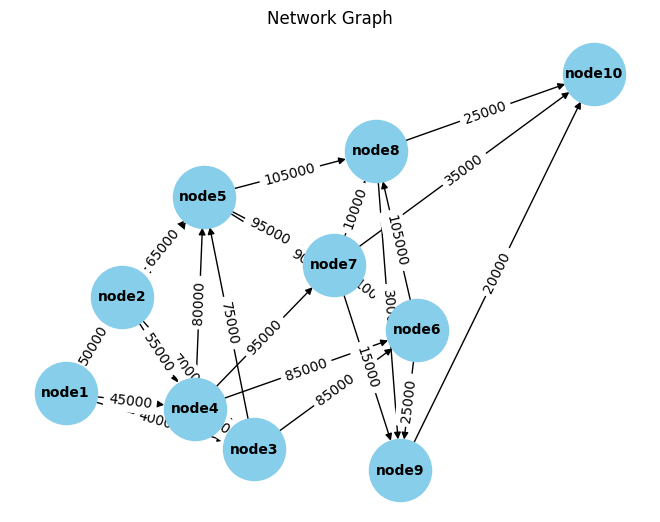

In [3]:
G = nx.DiGraph()

# Add nodes to the graph
for _, node in nodes.iterrows():
    G.add_node(node['pub_key'], alias=node['alias'])

# Add edges to the graph
for _, edge in channels.iterrows():
    G.add_edge(edge['node1_pub'], edge['node2_pub'], capacity=edge['capacity'], base_fee=edge['base_fee'], perc_fee=edge['perc_fee'])

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

# Add edge labels
edge_labels = {(u, v): f"{d['capacity']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Network Graph')
plt.show()

## Model

In [4]:
#channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.set_index("channel_id", inplace=True)
nodes.set_index("pub_key", inplace=True)

### Sets

In [5]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=channels.index) #within=model.NODES*model.NODES)

### Variables

In [6]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)

In [7]:
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals)

### Objective function

$$\min \sum _{(i,j) \in E} x_{i,j} \times (baseFee_{i,j} + rateFee_{i,j} \times amount_{i,j})$$

In [8]:
def objective_function(model: pyo.ConcreteModel):
    return sum(channels.loc[k]["base_fee"] * model.x[k] for k in model.CHANNELS) + sum(channels.loc[i]["perc_fee"] * model.a[i] for i in model.CHANNELS)

In [9]:
model.totalCost = pyo.Objective(expr=objective_function(model), sense=pyo.minimize)

### Constraints

#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [10]:
# Capacity constrain
def capacity_constraint(model: pyo.ConcreteModel, a):
    return model.a[a] <= channels.loc[a]["capacity"] * model.x[a]
model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{si} - \sum_{(i,t) \in E} amount_{it} = b_i \text{ } \forall i \in V$$

In [11]:
def compute_outgoing(n: str) -> list:
    """
    Compute outgoing channels list for the node n
    :param n: node identifier
    :return: list of outgoing channels for node n
    """
    return [c for c in model.CHANNELS if channels.loc[c]["node1_pub"] == n]


def compute_incoming(n: str) -> list:
    """
    Compute incoming channels list for the node n
    :param n: node identifier
    :return: list of incoming channels for node n
    """
    return [c for c in model.CHANNELS if channels.loc[c]["node2_pub"] == n]


In [12]:
# Flow constrain

def flow_balance_constraint(model: pyo.ConcreteModel, n):
    return sum(model.a[a] for a in compute_incoming(n)) - sum(model.a[a] for a in compute_outgoing(n)) == nodes.loc[n]["demand"]
model.FlowBalanceConstrain = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

## Solving the model

In [13]:
opt = pyo.SolverFactory('cbc')
opt.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp2zykstww.pyomo.lp -stat=1 -solve -solu /tmp/tmp2zykstww.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 28 (-7) rows, 40 (-10) columns and 82 (-18) elements
Statistics for presolved model
Original problem has 25 integers (25 of which binary)
Presolved problem has 21 integers (21 of which binary)
==== 0 zero objective 30 different
==== absolute objective values 30 different
==== for integers 0 zero objective 15 different
==== for integers absolute objective values 15 different
===== end objective counts


Problem has 28 rows, 40 columns (40 with objective) and 82 elements
There are 21 singletons with objective 
Column breakdown:
19 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 21 of type 0.0->1.0 
Row

{'Problem': [{'Name': 'unknown', 'Lower bound': 380.0, 'Upper bound': 380.0, 'Number of objectives': 1, 'Number of constraints': 28, 'Number of variables': 40, 'Number of binary variables': 25, 'Number of integer variables': 25, 'Number of nonzeros': 40, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.02, 'Wallclock time': 0.02, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.041512250900268555}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [14]:
model.x.pprint()

x : Size=25, Index=CHANNELS
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      1 :     0 :   0.0 :     1 : False : False : Binary
      2 :     0 :   0.0 :     1 : False : False : Binary
      3 :     0 :   0.0 :     1 : False : False : Binary
      4 :     0 :   0.0 :     1 : False : False : Binary
      5 :     0 :   0.0 :     1 : False : False : Binary
      6 :     0 :   0.0 :     1 : False : False : Binary
      7 :     0 :   0.0 :     1 : False : False : Binary
      8 :     0 :   0.0 :     1 : False : False : Binary
      9 :     0 :   0.0 :     1 : False : False : Binary
     10 :     0 :   0.0 :     1 : False : False : Binary
     11 :     0 :   1.0 :     1 : False : False : Binary
     12 :     0 :   0.0 :     1 : False : False : Binary
     13 :     0 :   0.0 :     1 : False : False : Binary
     14 :     0 :   0.0 :     1 : False : False : Binary
     15 :     0 :   0.0 :     1 : False : False : Binary
     16 :     0 :   0.0 :     1 : False : False : Binary
   

In [17]:
model.FlowBalanceConstrain.pprint()